In [194]:
import numpy as np
import networkx as nx
import collections

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import KMeans
from scipy import sparse 
from scipy import special
from scipy import optimize
import copy
import tqdm
import itertools
import time
import seaborn as sns 
import random

In [195]:
def neg(x):
    if x == 0:
        return 1
    else:
        return 0
    
def checkSign(vector):
    labels_pred = np.zeros(len(vector))
    median = np.median(vector)
    for i in range(len(vector)):
        if (vector[i]<0):
            labels_pred[i] = 1
    return labels_pred


def GetAccuracy(G, labels_pred):
    ground_labels_vals = set(nx.get_node_attributes(G, 'label').values())
    label_map = dict(zip(ground_labels_vals, range(len(ground_labels_vals))))
    ground_labels = list(nx.get_node_attributes(G, 'label').values())
    ground_labels = [label_map[v] for v in ground_labels]
    neg_labels_pred = list(map(neg, labels_pred))
        
    return max(accuracy_score(labels_pred, ground_labels), accuracy_score(neg_labels_pred, ground_labels))

def sp_real_eigsort(A, k = 10, which = 'SR'):
    vals, vecs = sparse.linalg.eigs(A, k = k, which = which)
    idx = np.real(vals).argsort()
    
    return vals[idx], vecs[:, idx]

def checkSign_minus(vector):
    labels_pred = np.ones(len(vector))
    for i in range(len(vector)):
        if (vector[i]<0):
            labels_pred[i] = -1
    return labels_pred

#     if isinstance(labels_pred, dict):
#         ground_labels_dict = nx.get_node_attributes(self, 'ground_label')
#         ground_labels = [ground_labels_dict[x] for x in labels_pred.keys()]
#         neg_labels_pred_list = [neg(v) for k, v in labels_pred.items()]
#         labels_pred_list = [v for k, v in labels_pred.items()]

#         # print(ground_labels)

#         return max(accuracy_score(labels_pred_list, ground_labels), accuracy_score(neg_labels_pred_list, ground_labels))

In [120]:
G = nx.read_adjlist('citeseer.cites')
labels = {}
with open('citeseer.content') as fh:
    for line in fh:
        cols = line.strip().split('\t')
        labels[cols[0]] = cols[-1]
collections.Counter(list(labels.values()))

Counter({'Agents': 596,
         'IR': 668,
         'DB': 701,
         'AI': 249,
         'HCI': 508,
         'ML': 590})

In [121]:
class_map = {'DB': 0,
 'IR': 1,
 'Agents': 2,
 'ML': 3,
 'HCI': 4,
 'AI': 5}
labels = {k: class_map[v] for k, v in labels.items()}
G = nx.subgraph(G, labels.keys())
nx.set_node_attributes(G, labels, 'label')

print("Number of nodes = %d" % G.number_of_nodes())

Number of nodes = 3312


In [196]:
classes_01 = [x for x,y in G.nodes(data=True) if y['label'] in [0,1]]
G_01 = nx.subgraph(G, classes_01)
# Take only the largest component of the graph
G_01 = nx.subgraph(G_01, max(nx.connected_components(G_01), key=len))
print("Number of nodes in two biggest classes: %d" % G_01.number_of_nodes())

Number of nodes in two biggest classes: 791


In [185]:
zero_label = 0
one_label = 1

class_0 = [x for x,y in G.nodes(data=True) if y['label'] == zero_label]
class_1 = [x for x,y in G.nodes(data=True) if y['label'] == one_label]
classes_01 = class_0 + class_1
# G_01 = nx.subgraph(G, classes_01)
# # Take only the largest component of the graph
# G_01 = nx.subgraph(G_01, max(nx.connected_components(G_01), key=len))

# class_0 = [x for x,y in G_01.nodes(data=True) if y['label'] == zero_label]
# class_1 = [x for x,y in G_01.nodes(data=True) if y['label'] == one_label]
if len(class_0) > len(class_1):
    balanced_class_0 = random.sample(class_0, len(class_1))
    balanced_class_1 = class_1
else:
    len_class_0 = len(class_0)
    balanced_class_1 = random.sample(class_1, k = len_class_0)
    balanced_class_0 = class_0
    
G_01 = nx.subgraph(G, balanced_class_0 + balanced_class_1)

print("Number of nodes in the class zero: %d" % len(balanced_class_0))
print("Number of nodes in the class one: %d" % len(balanced_class_1))
print(nx.is_connected(G_01))

Number of nodes in the class zero: 668
Number of nodes in the class one: 668
False


In [202]:
laplacian_matrix = nx.laplacian_matrix(G_01)
# print(laplacian_matrix)
n = G_01.number_of_nodes()
vals, vecs = sparse.linalg.eigs(laplacian_matrix.asfptype(), k = int(0.02 * n), which = 'SR')
# vals, vecs = sp_real_eigsort(A = laplacian_matrix.asfptype(), k = int(0.02 * n), which = 'SR')
# print(np.linalg.norm(vecs[:,1]))
accs = []
spectra = []
vec_idxs = range(len(vals))
for i in vec_idxs:
    vector = vecs[:,i]
    vector = vector.astype('float64')
    labels_pred = checkSign(vector)
    labels_pred_minus = checkSign_minus(vector)
    pred_dict = dict(zip(list(G_01.nodes), labels_pred))
    accuracy = GetAccuracy(G_01, labels_pred)
    accs += [accuracy]
    spectra += [vals[i] * np.linalg.norm(labels_pred_minus)**2]

/user/abobu/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


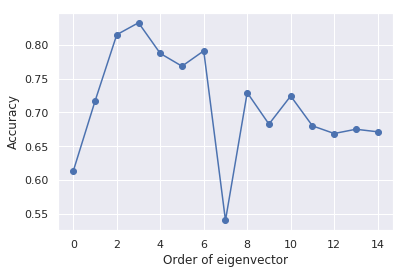

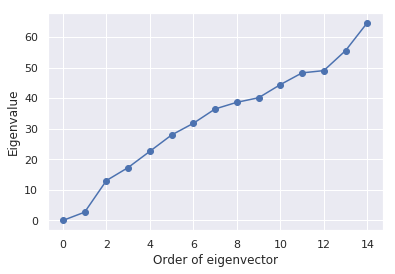

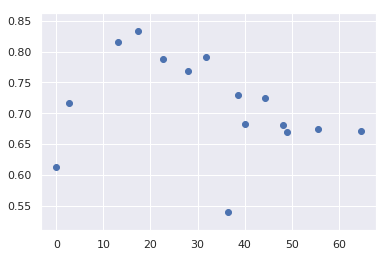

In [203]:
sns.set()
plt.plot(vec_idxs, accs, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Accuracy")
plt.savefig('citeseer-01-classes-acc-over-egv.png')
plt.show()

plt.plot(vec_idxs, spectra, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Eigenvalue")
plt.savefig('citeseer-01-classes-spectrum.png')
plt.show()

plt.scatter(spectra, accs, marker = 'o')
plt.show()

In [205]:
print(spectra)

[(-8.051185586277486e-13+0j), (2.6997446618549334+0j), (13.032229252297673+0j), (17.284793839914002+0j), (22.604058388869557+0j), (27.940678498637794+0j), (31.7543869676619+0j), (36.446446642728766+0j), (38.61799061162096+0j), (40.10702994272619+0j), (44.39759085765215+0j), (48.24071407975882+0j), (48.982929370155546+0j), (55.5174867291744+0j), (64.63459575628265+0j)]


In [75]:
adj_matrix = nx.adjacency_matrix(G_01).toarray()
nx.number_of_nodes(G_01)
# np.count_nonzero(~np.isfinite(laplacian))
# laplacian.shape

791

In [129]:
clustering = SpectralClustering(n_clusters = 2,
                                assign_labels = "discretize",
                                affinity = 'precomputed',
                                random_state = 0).fit(adj_matrix)

In [130]:
GetAccuracy(G_01, clustering.labels_)

0.7142857142857143

In [213]:
print(spectra[2])

(13.032229252297673+0j)


In [209]:
class_0 = [x for x,y in G_01.nodes(data=True) if y['label'] == 0]
class_1 = [x for x,y in G_01.nodes(data=True) if y['label'] == 1]

In [210]:
nx.cut_size(G_01, class_0)

140

In [216]:
idx = 2
labels_pred = checkSign(vecs[:,idx])
pred_dict = dict(zip(list(G_01.nodes), labels_pred))
print(vals[idx])
    
for v in class_0:
    if pred_dict[v] == 0:
        nx.set_node_attributes(G_01, {v: '00'}, name = 'ground_vs_pred')
    else:
        nx.set_node_attributes(G_01, {v: '01'}, name = 'ground_vs_pred')

for v in class_1:
    if pred_dict[v] == 0:
        nx.set_node_attributes(G_01, {v: '10'}, name = 'ground_vs_pred')
    else:
        nx.set_node_attributes(G_01, {v: '11'}, name = 'ground_vs_pred')

(0.016475637487101992+0j)


In [217]:
class_0 = [x for x,y in G_01.nodes(data=True) if y['ground_vs_pred'] in ['00', '10']]
class_1 = [x for x,y in G_01.nodes(data=True) if y['ground_vs_pred'] in ['01', '11']]
nx.cut_size(G_01, class_0)

14

/user/abobu/home/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


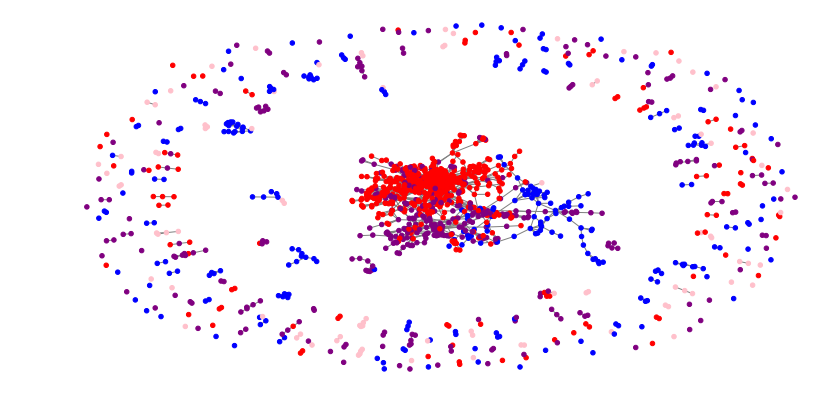

In [193]:
fig, ax1 = plt.subplots(1, 1, sharey = True, figsize=(14, 7))
pos = nx.spring_layout(G_01)
# color_map = {0: 'blue', 1: 'red'}
color_map = {'00': 'blue', '01': 'purple', '11': 'red', '10': 'pink'}
ground_colors = [color_map[G_01.nodes[node]["ground_vs_pred"]] for node in G_01.nodes]
nx.draw(G_01, pos, ax1, with_labels=False, node_color=ground_colors, edge_color = 'gray', node_size = 20)
plt.show()
plt.close() 